# Trabalho 04 - MAP para o GMM

Andreza Fernandes de Oliveira - 486243

### Observação: Professor, eu tô tendo um problema com a dimensão da mean, e daí bugou o resto de tudo (visualizações e etc). Bem, eu só copiei esse trecho da visualização do Felipe Marcel, porque pensei que como seria só a visualização, talvez não teria problema. Aí, bem, eu fiquei tentando resolver isso (sei que o erro é muito besta), e não tô conseguindo solucionar. Então prefiro enviar o que tentei do que copiar ou algo do tipo de alguém. Pelo menos aprendi :D Só não achei ainda o que raios ocasiona esse erro da dimensão da mean. Aí eu tô enviando assim logo, mas vou ficar tentando até meia noite resolver isso.

## 01. Implemente a solução MAP para o GMM (Gaussian Mixture Model) utilizando os dados disponíveis em clustering data.csv
- Testes com o método variando o numero de componentes do GMM (use 2, 4, 6, 8 e 10)

- Apresente uma figura com a distribuição a posteriori e os dados usados para treinamento.

### Importações

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 

from IPython.display import Image
%matplotlib inline
from scipy.stats import multivariate_normal
path = "/content/drive/MyDrive/Acadêmico/UFC/Mestrado/Disciplinas/2020.2/Tópicos Especiais em Lógica II/TRABALHOS/Trabalho 04/"

# Leitura dos dados

In [2]:
data = pd.read_csv(path+"clustering_data.csv", header=None)
data.head(10)

,0,1
0,-9.324269,-8.524550
1,-4.802893,4.568391
2,-9.151913,-7.235600
3,6.631406,6.885714
4,5.800550,7.154082
5,10.301027,4.888417
6,-4.442158,3.011477
7,5.061953,8.619590
8,8.593262,-2.328679
9,-3.598940,1.564484


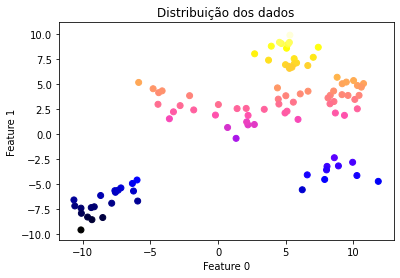

In [3]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='o', c=data.iloc[:, -1],cmap='gnuplot2')

plt.title(f'Distribuição dos dados')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1');


# Gaussian Mixture Model via MAP

### Modelos de misturas

*Bem, em problemas e em dados que nos deparamos e trabalhamos, podemos encontrar diferentes tipos de distribuições dentro de um mesmo conjunto de dados. Em conjunto de dados com a finalidade de classificação, podemos encontrar diferenciar classes dentro desse conjunto através do encontro da distribuição que origina cada classe (eu acho que não tô explicando direito com minhas palavras o que eu entendi, ajeitar isso aqui depois).*

Uma maneira de modelar variáveis correlacionadas é através de
modelos de variáveis latentes. Temos $z_i ∈ {1, . . . , K}$ como variável latente discreta. Com isso:

- A sua priori é dada por $p(z_i) = Cat(π)$, ou seja, $p(z_i = k) = πk$.
- Verossimilhança $p(x_i|z_i = k) = pk(xi)$ relacionando a variável latente $z_i$ e a observação $x_i$.

Daí, podemos obter o modelo de misturas marginalizando as K distribuições base:




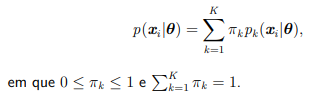

In [4]:
Image(filename=path+'/imgs/modelo_mistura_via_K_marginalizacao.png') 

Onde, 
- $θ$  são os parâmetros das distribuições para cada valor k da variável latente
- $π_k$ é o fator da variavel latente ter valor k

Com o modelo de misturas nas obervações dos padrões $x_i$ podemos encontrar qual *cluster* gerou o padrão calculando a posteriori $p(z_i = k|x_i
, θ)$.


### Misturas de Gaussianas

- Um dos mais usados para representação de dados contínuos.
- Tem como objetivo maximizar a função da verossimilhança com relação aos parâmetros (médias, covariâncias e coeficientes de mistura).

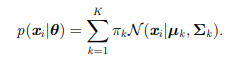

In [5]:
Image(filename=path+'/imgs/mistura_gaussiana.png') 

Aqui, usaremos a abordagem de **Expectation Maximization (EM)**, onde a partir da esperança, otimizaremos as variáveis em função de $θ$.

#### **Passo a passo do algoritmo**

Aqui temos um resumo do algoritmo que iremos implementar:

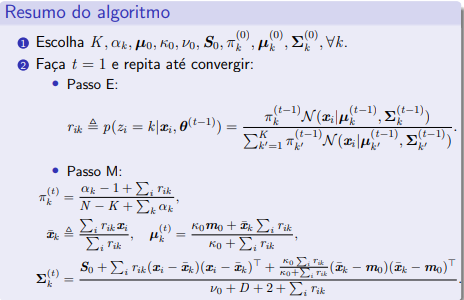

In [6]:
Image(filename=path+'/imgs/algoritmo.png') 

O **Passo E**, de *expectation*, descreve o processo de encontrar qual cluster gerou o padrão calculando a posteriori $p(z_i=k|x_i,θ)$. (dúvida se é isso mesmo, eu entendi isso aqui).

Já o **Passo M**, de *maximization*, que é a fase de refinar e atualizar o $θ$ para cada $k$. 

E assim, executamos essa sequência de passos: expectation > maximization > expectation > ... até o critério de parada ser atingido.


**Inicialização dos parâmetros utilizados**

Aqui a gente irá inicializar os parâmetros via KMeans

In [37]:
k = [2, 4, 6, 8, 10]

def init_hiperparams(x, k):
    mean_0 = KMeans(k).fit(data).cluster_centers_
    cov_0 = np.array([np.diag(np.var(x, axis=0)) for _ in range(k)])
    pi_0 = np.array([1/k for _ in range(k)])
    alphas = np.array([2 for _ in range(k)])

    return mean_0, cov_0, pi_0, alphas

mean_0, cov_0, pi_0, alphas_0 = init_hiperparams(data, 2)

**Passos E e M**

In [38]:
def r_ik(x, pi, mean, cov, k):
    first = pi[k] * multivariate_normal.pdf(x, mean=mean[k], cov=cov[k])
    second = np.sum([pi[p] * multivariate_normal.pdf(x, mean=mean[p], cov=cov[p]) for p in range(pi.shape[0])], axis=0)
    return first/second

def expectation_maximization(x, k_, num_iterations, mean_0, cov_0, pi_0, alpha_0):
    n, d = x.shape

    mean = mean_0.copy()
    cov = cov_0.copy()
    pi = pi_0.copy()
    alpha = alpha_0.copy()

    k_0 = 0
    v_0 = 4

    for _ in range(num_iterations):
        rs = np.zeros(k_)
        for k in range(k_):

            # ------- Expectation -------
            r = r_ik(x, pi, mean, cov, k)
            Nk = np.sum(r, axis=0)
            rs[k] = Nk

            # ------- Maximization -------
            # print("BEFORE", mean[k, :])
            pi[k] = (alpha[k] - 1 + Nk) / (n - k + np.sum(alpha))

            x_hat_k = r.dot(x) / Nk
            
            mean[k,:] = (k_0 * mean_0[k,:] + x_hat_k * Nk) / (k_0 + Nk)

            # print("AFTER", mean[k, :])

            # cov
            x_minus_x_hat_k = ((x - x_hat_k)*r[:, np.newaxis]).T.dot(x-x_hat_k)
            cov_k = (cov_0[k,:,:] + x_minus_x_hat_k + (k_0*Nk / (k_0 + Nk)) * np.outer(x_hat_k - mean_0[k,:], x_hat_k - mean_0[k,:]))
            cov_k = cov_k / (v_0 + d + 2 + Nk)

            cov[k,:,:] =  cov_k

    return mean, cov, pi, rs

In [39]:
mean, cov, pi, rs = expectation_maximization(data, 2, 10, mean_0, cov_0, pi_0, alphas_0)
mean, cov, pi, rs

(array([[-6.82028058, -3.36062937],
        [ 6.30115395,  3.58728864]]), array([[[ 6.94245299,  9.09034608],
         [ 9.09034608, 20.14090389]],
 
        [[ 8.20816618, -1.65291232],
         [-1.65291232, 14.0976772 ]]]), array([0.29866596, 0.68869314]), array([30.06126001, 69.93539385]))

**Análise de resultados**

In [81]:
def predict(x, mean, cov, pi, rs):
    K = mean.shape[0]

    # TAVA DANDO ERRO NA DIMENSÃO DA MÉDIA E EU N SEI OQ Q TAVA HAVENDO
    # eu até deixei igualzinho o do felipe, e não funciona! E meus neurônios não tão mais funcionando direito
    # rs = np.array([r_ik(x, mean, cov, pi, k) for k in range(K)])

    rs = np.array([rs for k in range(K)])
    j = np.argmax(rs, axis=0)
    probs = np.array([multivariate_normal(mean[k], cov[k]).pdf(x) for x_, k in zip(x, j)])
    return probs, j
    # return j

In [ ]:
predict(data, mean, cov, pi, rs)

In [86]:
# Peguei essa visualização do notebook do Marcel kkkkkk mas não tá dando DDDDD:
x = y = np.linspace(-15,15,200)
fill = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
probabilities,_ = predict(fill, mean, cov, pi, rs)
_,classes = predict(data, mean, cov, pi, rs)

plt.figure(figsize=(20, 7))
probs = probabilities.reshape(200,200)
plt.imshow(probs, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(data[0], data[1], marker='o', c=classes,s=40, edgecolor='k', cmap=plt.cm.Paired)

ValueError: ignored

<Figure size 1440x504 with 0 Axes>

**GMM com 2 componentes**

In [89]:
k = 2
num_inter = 200
mean, cov, pi, rs = expectation_maximization(data, k, num_inter, mean_0, cov_0, pi_0, alphas_0)

print("MEAN: ", mean)
print("COV: ", cov)
print("PI: ", pi)
print("Rs: ", rs)


MEAN:  [[-6.81852763 -3.35890057]
 [ 6.30171204  3.58735789]]
COV:  [[[ 6.94966415  9.09647211]
  [ 9.09647211 20.14469933]]

 [[ 8.20493463 -1.65344455]
  [-1.65344455 14.09852086]]]
PI:  [0.29874959 0.68864119]
Rs:  [30.06995713 69.93004287]


In [90]:
# Peguei essa visualização do notebook do Marcel kkkkkk mas não tá dando DDDDD:
x = y = np.linspace(-15,15,200)
fill = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
probabilities,_ = predict(fill, mean, cov, pi, rs)
_,classes = predict(data, mean, cov, pi, rs)

plt.figure(figsize=(20, 7))
probs = probabilities.reshape(200,200)
plt.imshow(probs, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(data[0], data[1], marker='o', c=classes,s=40, edgecolor='k', cmap=plt.cm.Paired)

ValueError: ignored

<Figure size 1440x504 with 0 Axes>

**GMM com 4 componentes**

In [91]:
k = 4
num_inter = 200
mean, cov, pi, rs = expectation_maximization(data, k, num_inter, mean_0, cov_0, pi_0, alphas_0)

print("MEAN: ", mean)
print("COV: ", cov)
print("PI: ", pi)
print("Rs: ", rs)


IndexError: ignored

In [95]:
x = y = np.linspace(-15,15,200)
fill = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
probabilities,_ = predict(fill, mean, cov, pi, rs)
_,classes = predict(data, mean, cov, pi, rs)

plt.figure(figsize=(20, 7))
probs = probabilities.reshape(200,200)
plt.imshow(probs, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(data[0], data[1], marker='o', c=classes,s=40, edgecolor='k', cmap=plt.cm.Paired)

ValueError: ignored

<Figure size 1440x504 with 0 Axes>

**GMM com 6 componentes**

In [92]:
k = 6
num_inter = 200
mean, cov, pi, rs = expectation_maximization(data, k, num_inter, mean_0, cov_0, pi_0, alphas_0)

print("MEAN: ", mean)
print("COV: ", cov)
print("PI: ", pi)
print("Rs: ", rs)


IndexError: ignored

In [96]:
x = y = np.linspace(-15,15,200)
fill = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
probabilities,_ = predict(fill, mean, cov, pi, rs)
_,classes = predict(data, mean, cov, pi, rs)

plt.figure(figsize=(20, 7))
probs = probabilities.reshape(200,200)
plt.imshow(probs, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(data[0], data[1], marker='o', c=classes,s=40, edgecolor='k', cmap=plt.cm.Paired)

ValueError: ignored

<Figure size 1440x504 with 0 Axes>

**GMM com 8 componentes**

In [93]:
k = 8
num_inter = 200
mean, cov, pi, rs = expectation_maximization(data, k, num_inter, mean_0, cov_0, pi_0, alphas_0)

print("MEAN: ", mean)
print("COV: ", cov)
print("PI: ", pi)
print("Rs: ", rs)


IndexError: ignored

In [97]:
x = y = np.linspace(-15,15,200)
fill = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
probabilities,_ = predict(fill, mean, cov, pi, rs)
_,classes = predict(data, mean, cov, pi, rs)

plt.figure(figsize=(20, 7))
probs = probabilities.reshape(200,200)
plt.imshow(probs, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(data[0], data[1], marker='o', c=classes,s=40, edgecolor='k', cmap=plt.cm.Paired)

ValueError: ignored

<Figure size 1440x504 with 0 Axes>

**GMM com 10 componentes**

In [94]:
k = 10
num_inter = 200
mean, cov, pi, rs = expectation_maximization(data, k, num_inter, mean_0, cov_0, pi_0, alphas_0)

print("MEAN: ", mean)
print("COV: ", cov)
print("PI: ", pi)
print("Rs: ", rs)


IndexError: ignored

In [98]:
x = y = np.linspace(-15,15,200)
fill = np.dstack(np.meshgrid(x,y)).reshape(-1,2)
probabilities,_ = predict(fill, mean, cov, pi, rs)
_,classes = predict(data, mean, cov, pi, rs)

plt.figure(figsize=(20, 7))
probs = probabilities.reshape(200,200)
plt.imshow(probs, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(data[0], data[1], marker='o', c=classes,s=40, edgecolor='k', cmap=plt.cm.Paired)

ValueError: ignored

<Figure size 1440x504 with 0 Axes>

## Bibliografia

- Slides de aula
- Pattern Recognition and Machine Learning, BISHOP, Christopher M